In [1]:
""" Veri Seti Yükleme ve Grafiklerin Ayarları"""
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Görsel ayarlar - Seaborn ve Matplotlib için daha büyük ve daha net grafikler
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='darkgrid')

# Veri yükle
LABELED_DATA_PATH = Path("../data/processed/metropt3_labeled.parquet")
df = pl.read_parquet(LABELED_DATA_PATH)

print(f"Veri yüklendi: {df.shape[0]:,} satır, {df.shape[1]} sütun")

Veri yüklendi: 1,516,948 satır, 19 sütun


In [2]:
# Saatlik ortalamayla downsample — 1.5M satır → ~5000 satır
df_hourly = (
    df.with_columns(
        pl.col('timestamp').dt.truncate('1h').alias('hour')     # zamandaki küsüratları atarak saatlik gruplama için yeni bir direkt saat sütun oluşturuyoruz
    )
    .group_by('hour')   # sadece saat sütununa göre gruplama yapıyoruz
    .agg([      # sensörlerin ortalamasını alıyoruz
        pl.col('TP2').mean(),
        pl.col('TP3').mean(),
        pl.col('Oil_temperature').mean(),
        pl.col('Motor_current').mean(),
        pl.col('is_suspect').max()  # Herhangi bir saat diliminde şüpheli bir tane sensör varsa bile o saati şüpheli olarak işaretle
    ])
    .sort('hour')   # saatlere göre sıralama yaparak zaman serisi analizine uygun hale getiriyoruz
)

print(f"Downsample sonrası: {df_hourly.shape[0]:,} satır")
print(df_hourly.head(5))

Downsample sonrası: 4,416 satır
shape: (5, 6)
┌─────────────────────┬──────────┬──────────┬─────────────────┬───────────────┬────────────┐
│ hour                ┆ TP2      ┆ TP3      ┆ Oil_temperature ┆ Motor_current ┆ is_suspect │
│ ---                 ┆ ---      ┆ ---      ┆ ---             ┆ ---           ┆ ---        │
│ datetime[μs]        ┆ f32      ┆ f32      ┆ f32             ┆ f32           ┆ i32        │
╞═════════════════════╪══════════╪══════════╪═════════════════╪═══════════════╪════════════╡
│ 2020-02-01 00:00:00 ┆ 0.502011 ┆ 8.881566 ┆ 51.893749       ┆ 0.89737       ┆ 0          │
│ 2020-02-01 01:00:00 ┆ 0.241003 ┆ 8.984066 ┆ 51.912395       ┆ 1.009373      ┆ 0          │
│ 2020-02-01 02:00:00 ┆ 0.485587 ┆ 9.014171 ┆ 51.719009       ┆ 1.281343      ┆ 0          │
│ 2020-02-01 03:00:00 ┆ 0.492347 ┆ 8.98157  ┆ 51.396763       ┆ 1.286625      ┆ 0          │
│ 2020-02-01 04:00:00 ┆ 0.508242 ┆ 8.996972 ┆ 52.172802       ┆ 1.265721      ┆ 0          │
└─────────────────────┴─

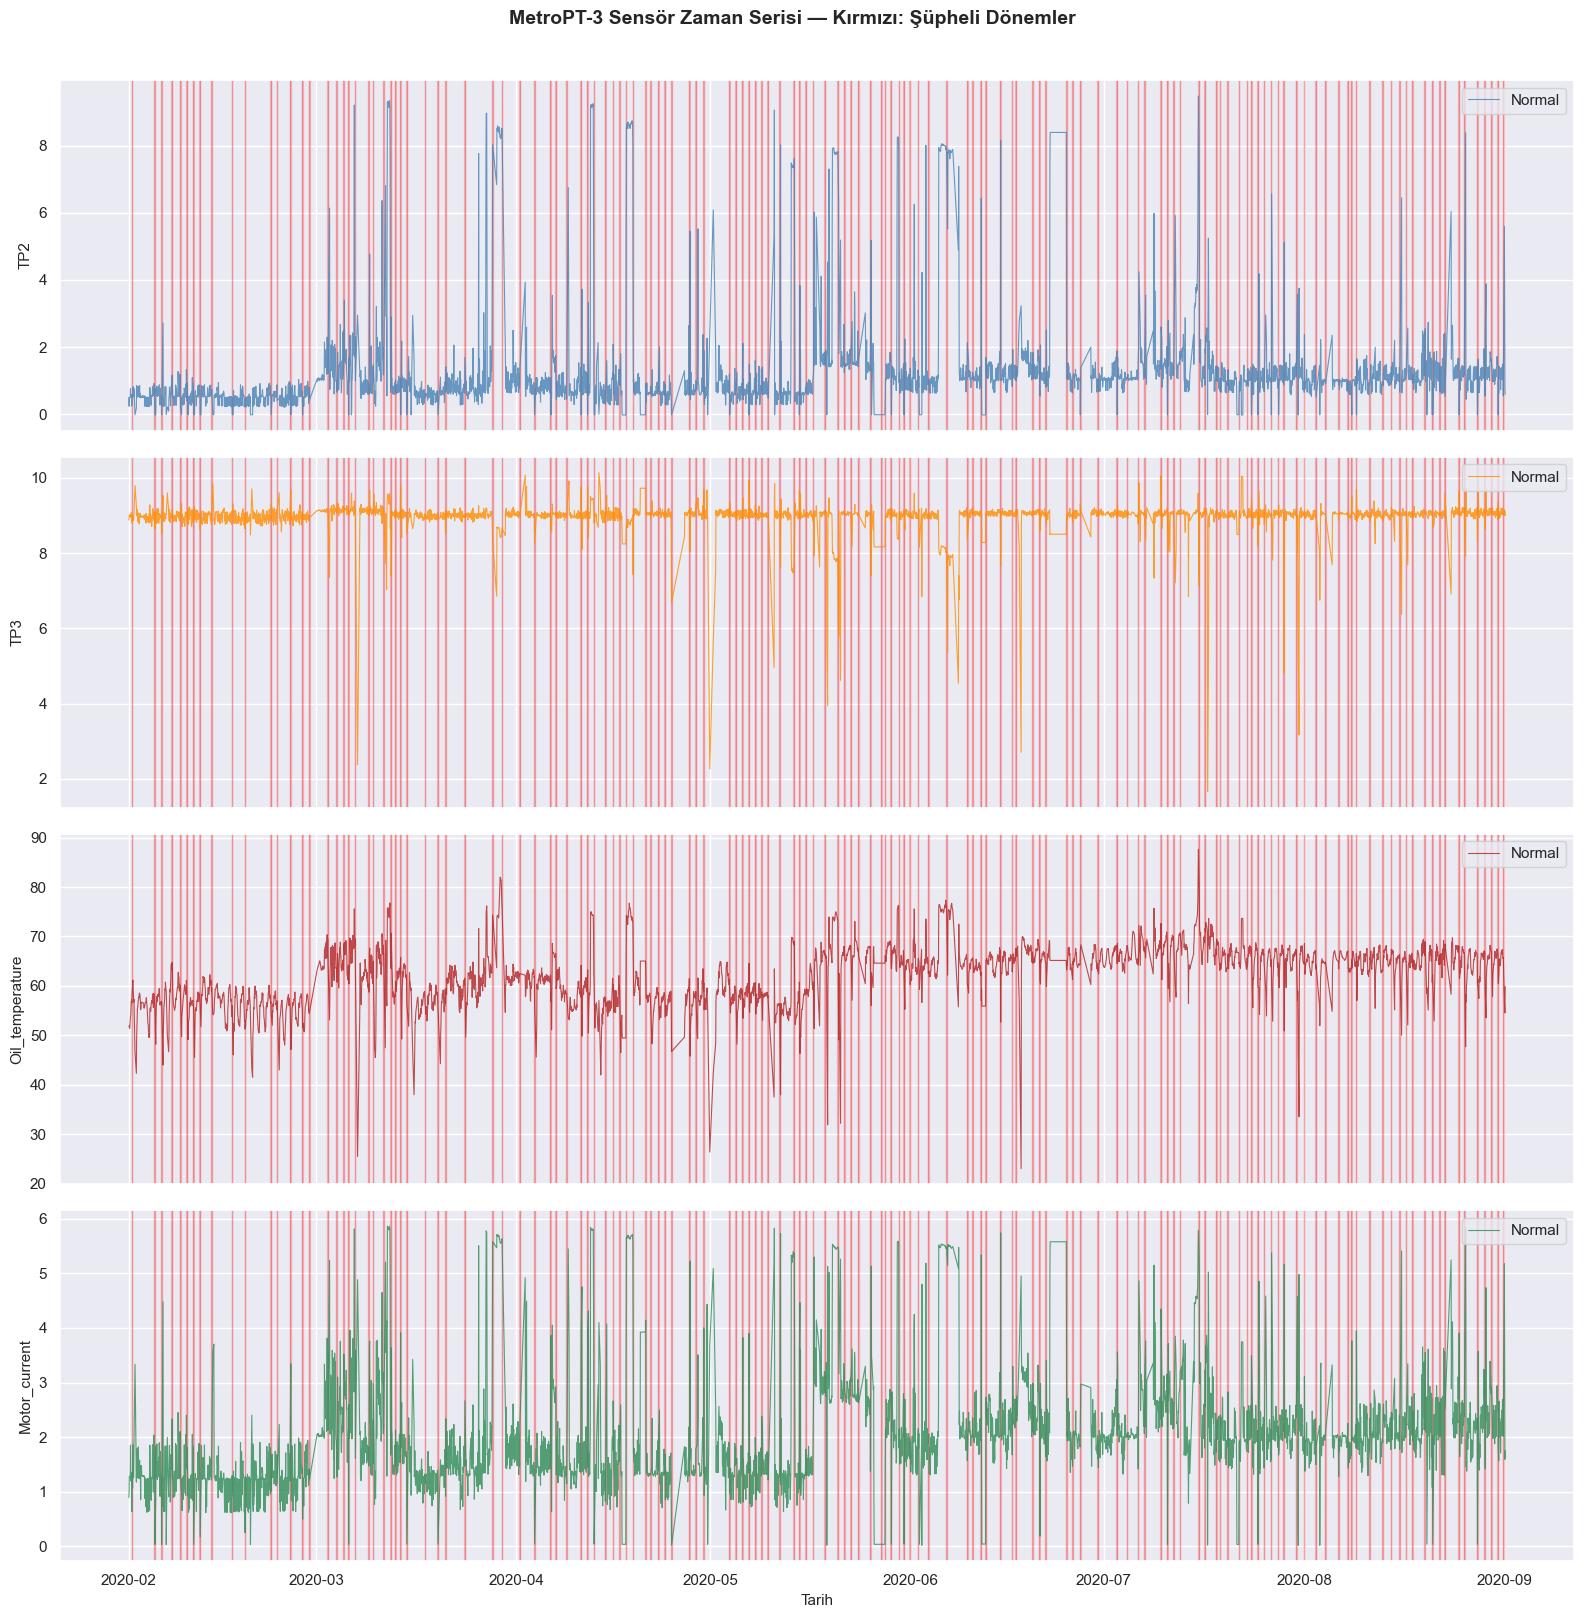

Grafik kaydedildi ✓


In [3]:
# Pandas'a çevir — matplotlib için gerekli
df_plot = df_hourly.to_pandas()

# Şüpheli dönemleri ayır
suspect_hours = df_plot[df_plot['is_suspect'] == 1]

# 4 sensörü ayrı ayrı çiz
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

sensors = ['TP2', 'TP3', 'Oil_temperature', 'Motor_current']
colors = ['steelblue', 'darkorange', 'firebrick', 'seagreen']

for ax, sensor, color in zip(axes, sensors, colors):
    # Normal dönem
    ax.plot(df_plot['hour'], df_plot[sensor], 
            color=color, linewidth=0.8, alpha=0.8, label='Normal')
    
    # Şüpheli dönemleri kırmızı arka planla vurgula
    for _, row in suspect_hours.iterrows():
        ax.axvspan(row['hour'], row['hour'] + pd.Timedelta(hours=1),
                   alpha=0.15, color='red')
    
    ax.set_ylabel(sensor, fontsize=11)
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Tarih', fontsize=11)
fig.suptitle('MetroPT-3 Sensör Zaman Serisi — Kırmızı: Şüpheli Dönemler', 
             fontsize=14, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('../reports/figures/01_timeseries_overview.png', 
            bbox_inches='tight', dpi=150)
plt.show()
print("Grafik kaydedildi ✓")

İstatistiksel olarak incelenebilir durumdaydı %8,7 şüpheli oran vardı ancak durumlar birbiri ile çok bitişik olduğundan gürültüyü arttırarak görsel analizi çok zorlaştırmış. 

Burada 2. yolu izleyeceğiz kısa kapanmaların çoğu öğle molası, vardiya değişimi, rutin bakım vb. olabileceğinden Bunların öncesi kısmi şüpheli değildir diyebiliriz. Bundan dolayı doğru analizi ve eğitimi yapabilmek için arıza oladuğu çok daha muhtemel olan uzun kapanmaları baz alıcaz. Uzunluk olarak da 12 saatten uzun oturumların son 2 saatini şüpheli olarak işaretleyerek bu işlemleri yapıcaz. (02_proc. dosyasında gerekli güncelleme yapıldı ancak durum sadece %2 düzeldi halen çok fazla çizgiler üst üste incelenemiyor)

Toplam şüpheli blok: 142


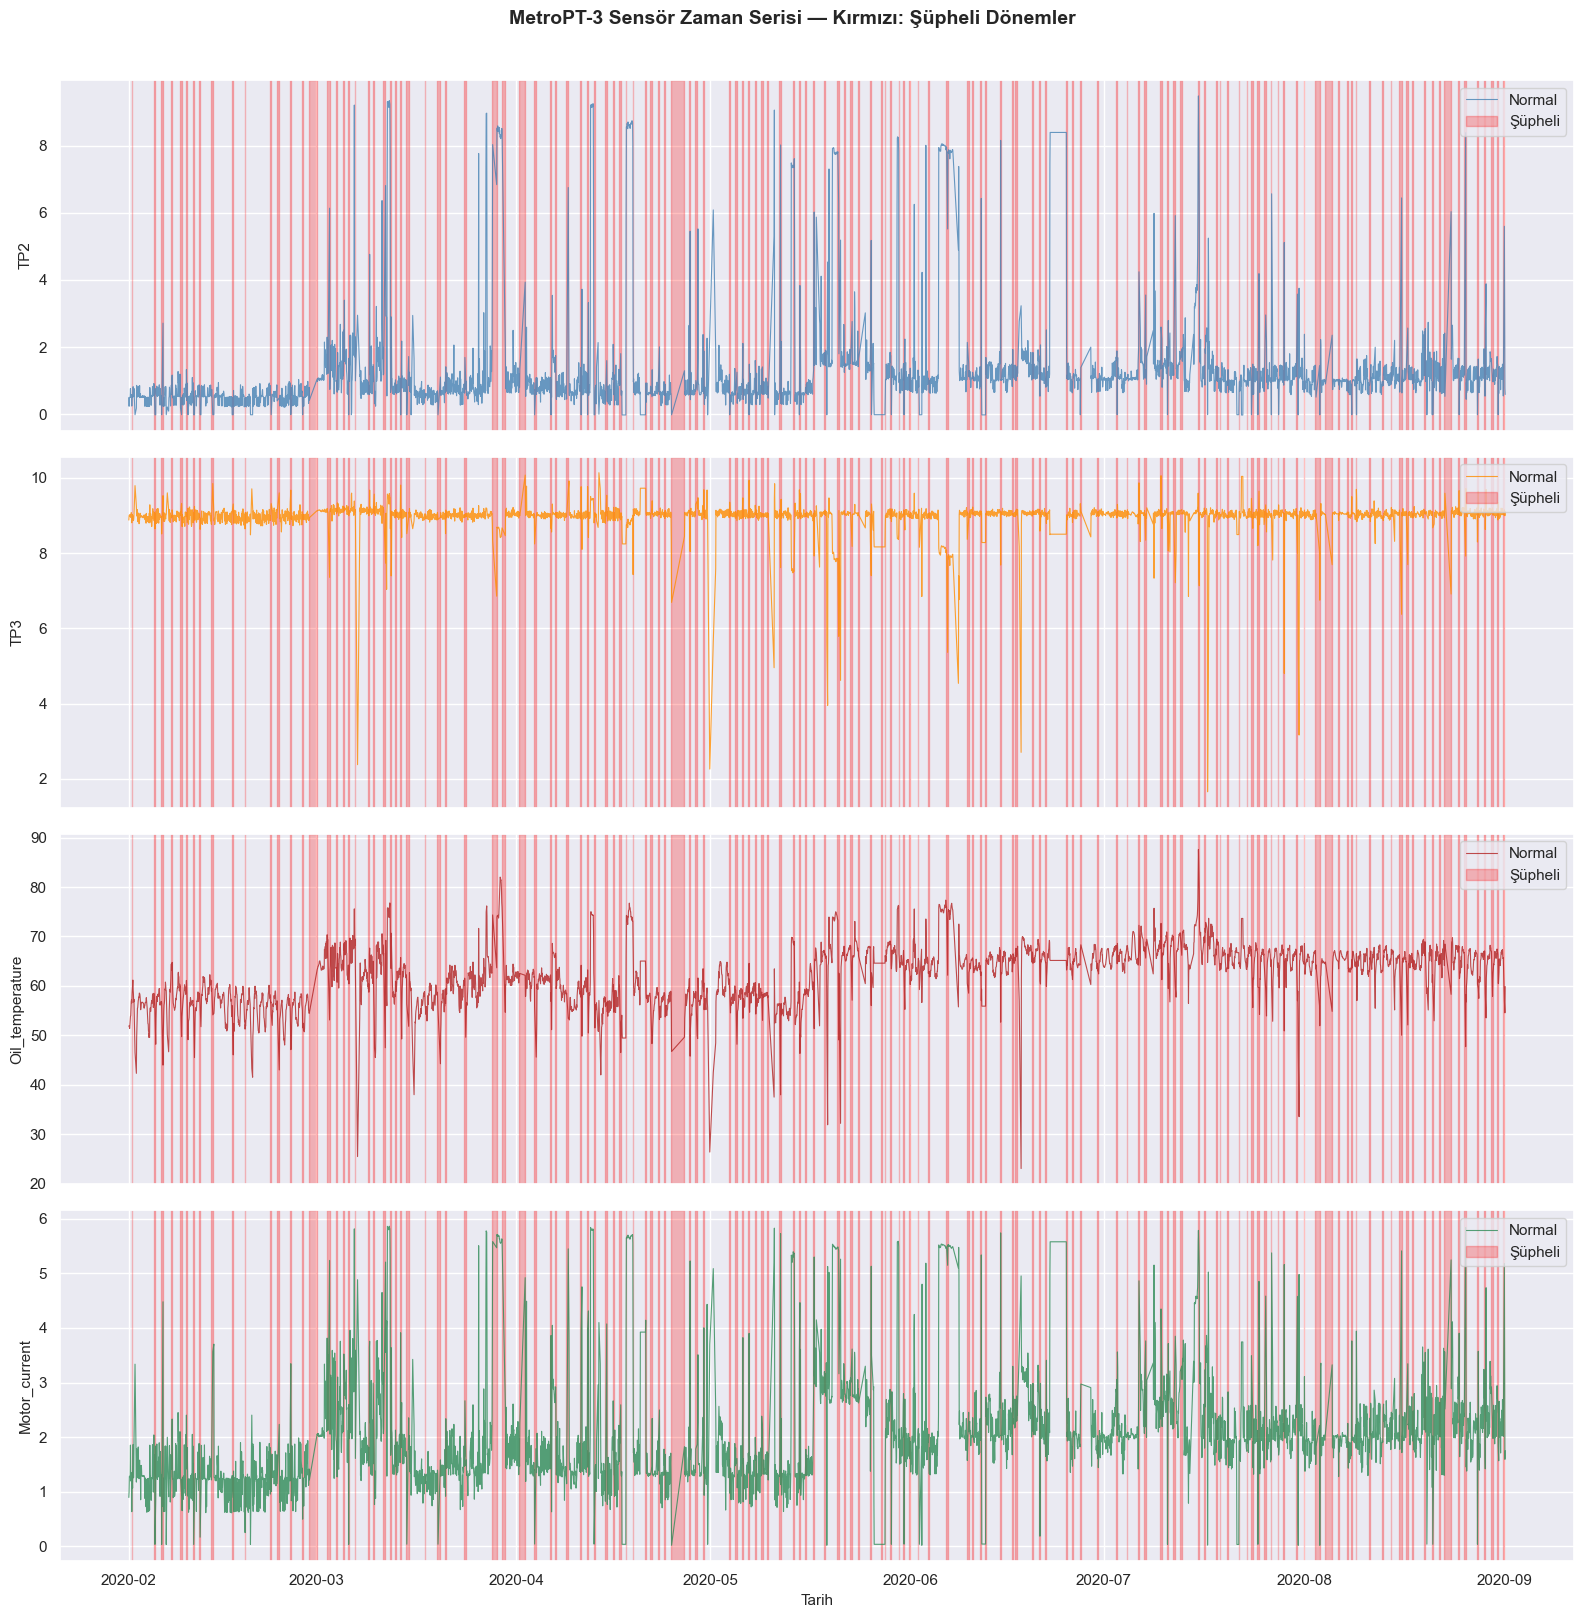

Grafik kaydedildi ✓


In [4]:
""" Bitişik Blokları Birleştirme """
df_plot = df_hourly.to_pandas()     # matplotlib ile çizim için pandas DataFrame'e dönüştürüyoruz

# Şüpheli blokları birleştir — bitişik saatleri tek blok yap
suspect_blocks = [] # birleştirilmiş blokları tutacak liste
in_block = False
block_start = None

for _, row in df_plot.iterrows():   # her dönemim başlangç ve bitiş saatlerini tutmak için DataFrame'i satır satır dolaşıyoruz
    if row['is_suspect'] == 1 and not in_block: # şüpheli bir dönem başladıysa ve şu anda bir blokta değilsek, yeni bir blok başlatıyoruz
        block_start = row['hour']
        in_block = True
    elif row['is_suspect'] == 0 and in_block: # şüpheli bir dönem sona erdiğinde ve şu anda bir blokta isek, bloğu kapatıyoruz
        suspect_blocks.append((block_start, row['hour']))
        in_block = False

if in_block:    # aldığımız bloğu baştaki listeye atıyoruz
    suspect_blocks.append((block_start, df_plot['hour'].iloc[-1])) 

print(f"Toplam şüpheli blok: {len(suspect_blocks)}")

# Grafik
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True) # 4 e 1 grafik

sensors = ['TP2', 'TP3', 'Oil_temperature', 'Motor_current']
colors = ['steelblue', 'darkorange', 'firebrick', 'seagreen']

for ax, sensor, color in zip(axes, sensors, colors):
    ax.plot(df_plot['hour'], df_plot[sensor],
            color=color, linewidth=0.8, alpha=0.8, label='Normal')
    
    # Birleştirilmiş blokları çiz
    for i, (start, end) in enumerate(suspect_blocks):
        ax.axvspan(start, end, alpha=0.25, color='red',
                   label='Şüpheli' if i == 0 else '')
    
    ax.set_ylabel(sensor, fontsize=11)
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Tarih', fontsize=11)
fig.suptitle('MetroPT-3 Sensör Zaman Serisi — Kırmızı: Şüpheli Dönemler',
             fontsize=14, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('../reports/figures/01_timeseries_overview.png',
            bbox_inches='tight', dpi=150)
plt.show()
print("Grafik kaydedildi ✓")

Bitişik şüpheli saatleri önce tek blok olarak birleştiriyoruz sonra çizdirdik ancak halen çok karışık ve analiz edilemez durumda. Kompresör günde birden fazla açılıp kapandığından çok fazla şüpheli durum oluşuyor bu da analiz edilemez duruma geliyor. alternatif yaklaşımı deniycez: Oturum bazlı değil gün bazlı düşünelim

In [8]:
""" Günlük Bazda Oturumlar """
df_daily = (
    df.with_columns(
        pl.col('timestamp').dt.truncate('1d').alias('day') # zaman damgasını gün bazında gruplamak için yeni bir 'day' sütunu oluşturuyoruz
    )
    .group_by('day')    # takvim günlerine göre gruplama yapılır
    .agg([      # toplulaştırma işlemi yapılır - o günkü sensörlerin ortalaması, o günün toplam çalışma süresi ve şüpheli kayıt oranı
        pl.col('TP2').mean(),
        pl.col('TP3').mean(),
        pl.col('Oil_temperature').mean(),
        pl.col('Motor_current').mean(),
        # O gün toplam çalışma süresi (saat)
        (pl.col('timestamp').count() * 10 / 3600).alias('active_hours'), # veriler 10sn de bir yani frekansla çarpılıp 3600e bölünce cihazın saat aktifliği bulunur
        # O gün şüpheli kayıt oranı
        pl.col('is_suspect').mean().alias('suspect_ratio')  # yoğunluklu günlerdeki şüpheli kayıt oranını bulmak için şüpheli kayıtların ortalamasını alıyoruz graifikte kullanılacak önemli parametre
    ])
    .sort('day')
)

print(f"Toplam gün: {df_daily.shape[0]}")
print(df_daily.head(5))

Toplam gün: 212
shape: (5, 7)
┌───────────────┬──────────┬──────────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ day           ┆ TP2      ┆ TP3      ┆ Oil_temperatu ┆ Motor_curren ┆ active_hours ┆ suspect_rati │
│ ---           ┆ ---      ┆ ---      ┆ re            ┆ t            ┆ ---          ┆ o            │
│ datetime[μs]  ┆ f32      ┆ f32      ┆ ---           ┆ ---          ┆ f64          ┆ ---          │
│               ┆          ┆          ┆ f32           ┆ f32          ┆              ┆ f64          │
╞═══════════════╪══════════╪══════════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ 2020-02-01    ┆ 0.532965 ┆ 8.968314 ┆ 55.748116     ┆ 1.292689     ┆ 19.844444    ┆ 0.101764     │
│ 00:00:00      ┆          ┆          ┆               ┆              ┆              ┆              │
│ 2020-02-02    ┆ 0.588232 ┆ 8.983974 ┆ 55.820084     ┆ 1.382803     ┆ 19.530556    ┆ 0.0          │
│ 00:00:00      ┆          ┆          ┆               ┆      

Veriler günlük bazda gruplandı ve sensörlerin günlük baz için ortalama aktifliğiyle daily kolonları oluşturuldu. Şüpheli durum oranlarıda bulunda sonraki grafikte yoğunluk durumu için kullanılacak

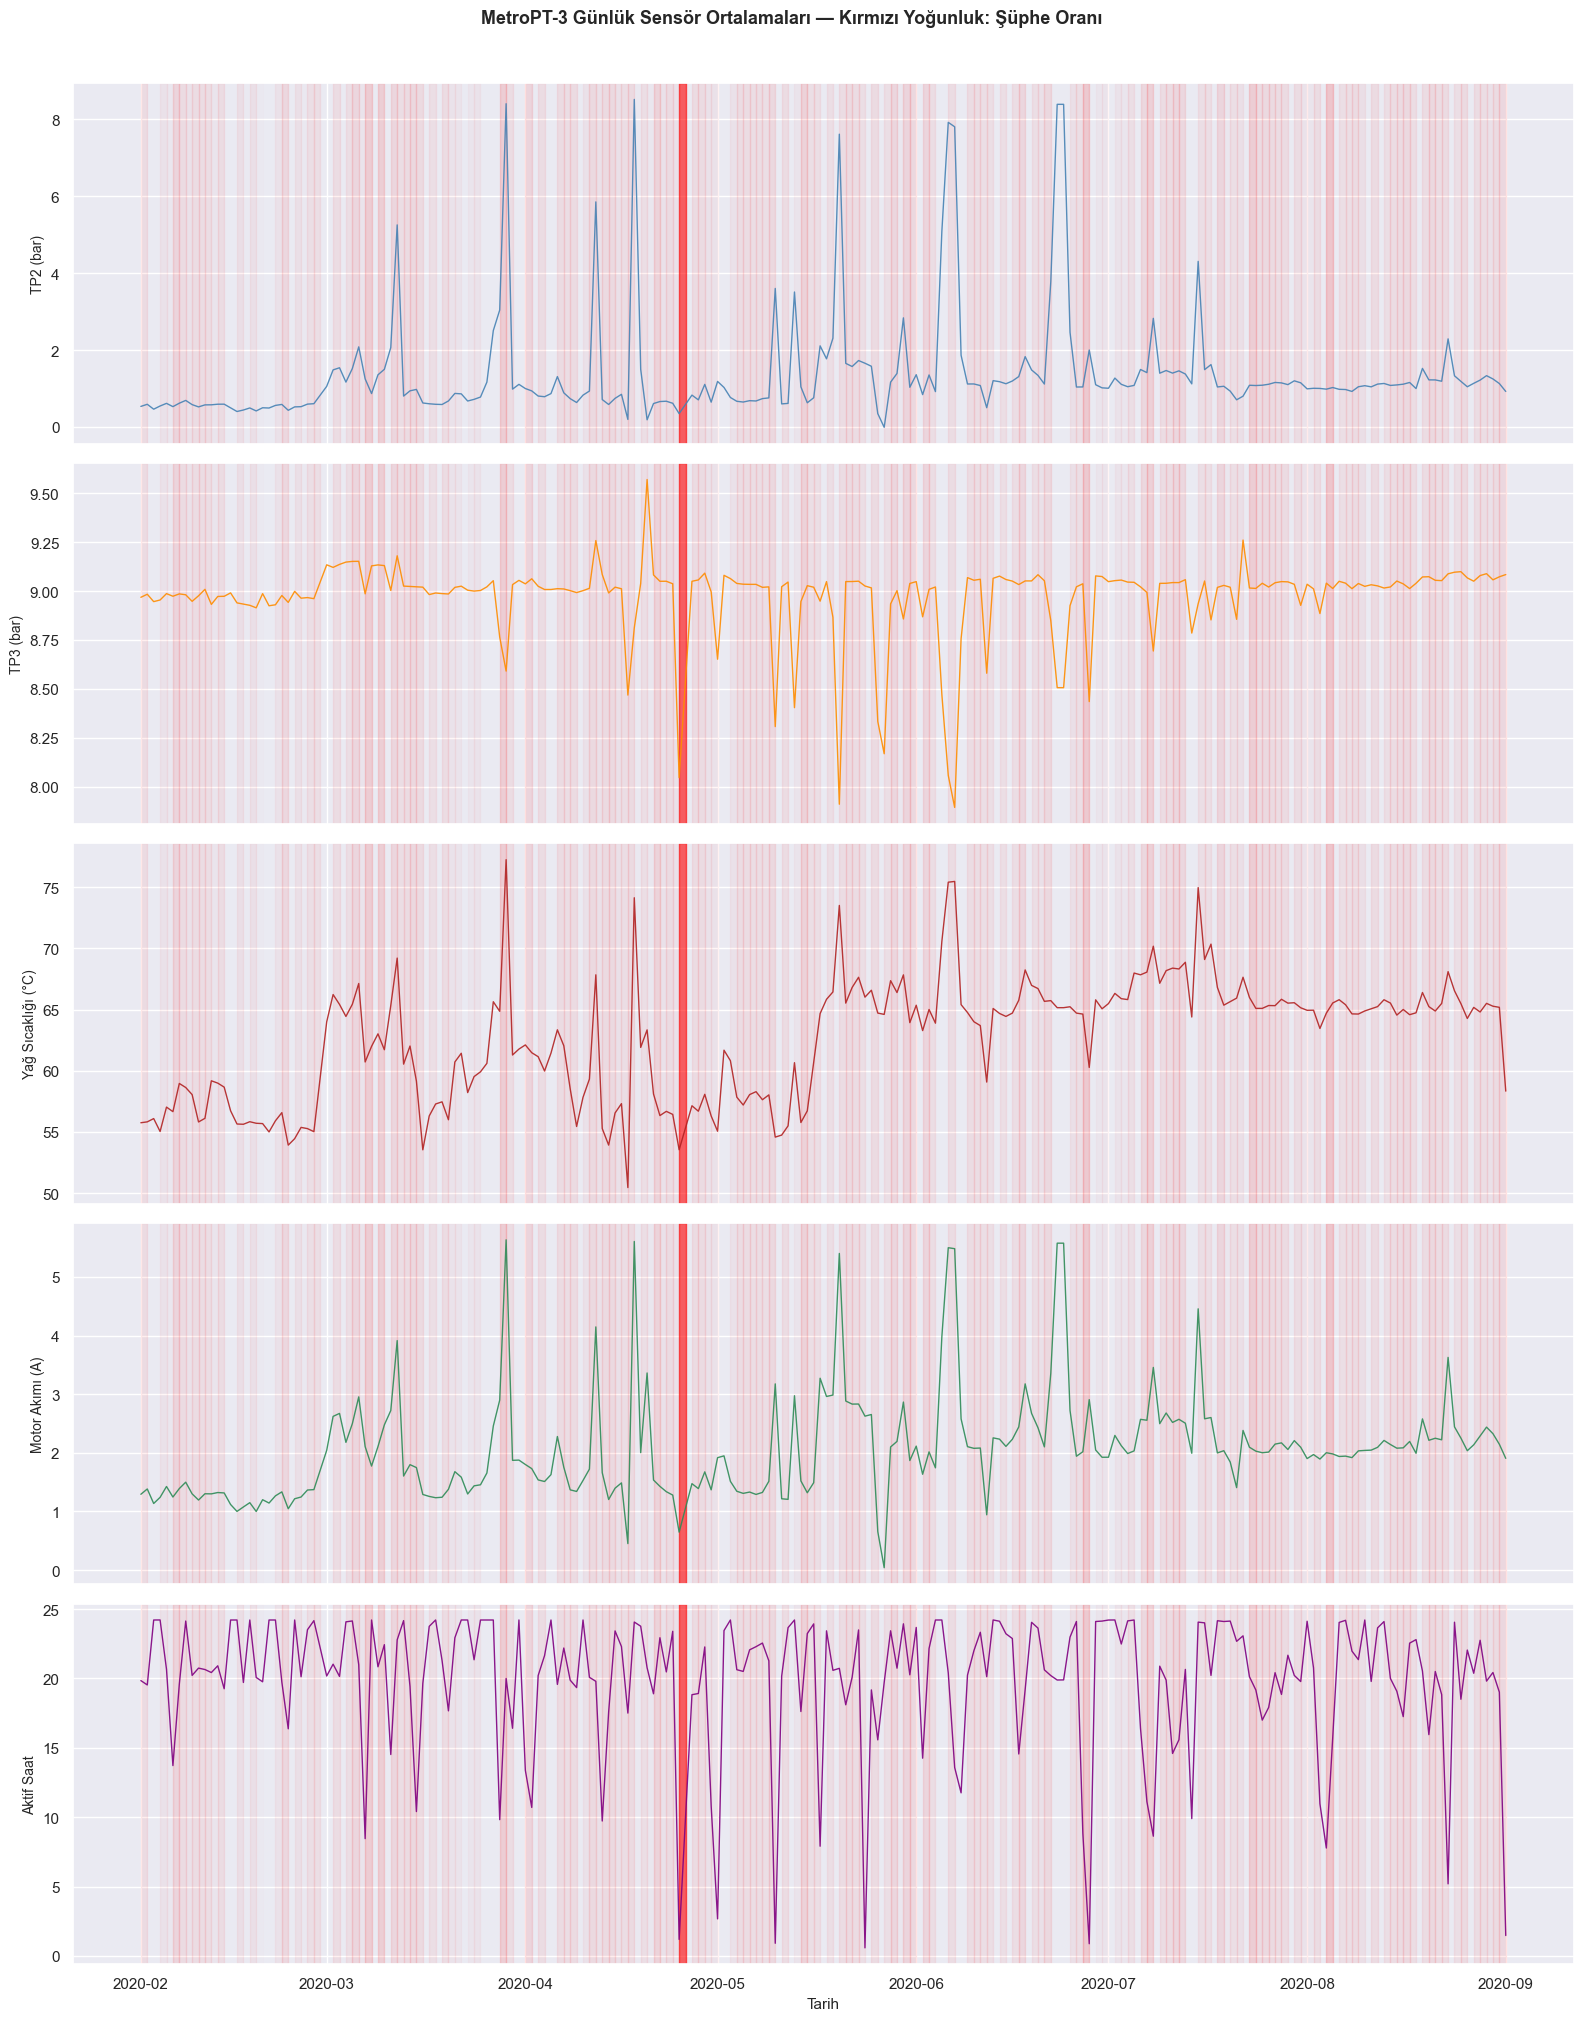

Grafik kaydedildi ✓


In [7]:
""" Güne Göre Şüpheli Durum Çokluğu — Yoğunluk Grafiği """
df_daily_pd = df_daily.to_pandas()  # yine hepsi aynı işlemler df dönüştür ve grafik özellikleri gir

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True)

sensors = ['TP2', 'TP3', 'Oil_temperature', 'Motor_current', 'active_hours']
colors = ['steelblue', 'darkorange', 'firebrick', 'seagreen', 'purple']
labels = ['TP2 (bar)', 'TP3 (bar)', 'Yağ Sıcaklığı (°C)', 'Motor Akımı (A)', 'Aktif Saat']

for ax, sensor, color, label in zip(axes, sensors, colors, labels):
    # Sensör değerini çiz
    ax.plot(df_daily_pd['day'], df_daily_pd[sensor],
            color=color, linewidth=1, alpha=0.9)
    
    # Şüpheli günleri arka plan rengiyle vurgula — suspect_ratio'ya göre yoğunluk
    for _, row in df_daily_pd.iterrows():
        if row['suspect_ratio'] > 0:
            ax.axvspan(row['day'], row['day'] + pd.Timedelta(days=1),
                      alpha=row['suspect_ratio'] * 0.6, color='red')
    
    ax.set_ylabel(label, fontsize=10)

axes[-1].set_xlabel('Tarih', fontsize=11)
fig.suptitle('MetroPT-3 Günlük Sensör Ortalamaları — Kırmızı Yoğunluk: Şüphe Oranı',
             fontsize=13, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('../reports/figures/02_daily_overview.png',
            bbox_inches='tight', dpi=150)
plt.show()
print("Grafik kaydedildi ✓")

Yoğun şüphe çeken oturum dilimleri daha yoğun kırmızılıktadır (suspect_ratio değerine göre 0-1 arasında). Burada dilim ayrımı da genişletildiğinden (günlük baz yapmıştık) şüpheli durumlar toplu ve bir arada gözükerek daha analiz edilebilir hale geldi. 

2020-05 başında kalın kırmızı çizgi. neredeyse tüm gün şüpheli. Aynı anda TP2, Motor_current sıfıra düşmüş, aktif saat minimumda.

yağ sıcaklığında marttan itibaren 10derece yükseliş olmuş ve bu kalıcı hale gelmiş mevsimsel olabilir. (faz 4 de bu anomaliler incelenecek)

motor mart-nisan zamanlarında ciddi pikler yapmış yük altına binmiş olabilir bu da arıza habercisi olabilir.